<a href="https://colab.research.google.com/github/alexjmanlove/ethics2team7/blob/main/Team7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ethics 2: Coursework 1 - Team 7**


## **Overview**

The idea of this notebook is to explore ways to evaluate the significance of predictors/features in a binary classification problem.

To do this, we take inspiration from **Shapley values** and consider how the ROC curve / Area Under Curve changes with the addition/removal of a given predictor X_i.


✔ **Pros**: 
* This method is model agnostic. 
* This method is fairly easy to interpret.

❌ **Cons**:
* This method involves computing one model for each element in the powerset of predictors. This has computational complexity O(2^p), where p is the number of predictors. Therefore it is not recommended to perform this analysis for a large number of predictors. 



In [ ]:
# requires latest matplotlib
!pip install matplotlib -U

In [ ]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# to remove pesky warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
''' Powerset function for convenience
adapted from https://stackoverflow.com/questions/1482308/how-to-get-all-subsets-of-a-set-powerset

INPUT: an iterable like a list,tuple,etc.
OUTPUT: a list of all possible subsets of the iterable. 
'''
def powerset(s):
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1, 1 << x):
        yield [ss for mask, ss in zip(masks, s) if i & mask]

# example
list(powerset([1,2,3]))

[[1], [2], [1, 2], [3], [1, 3], [2, 3], [1, 2, 3]]

## **Generating Synthetic Data and EDA**

In [ ]:
from sklearn import datasets
'''
 Note in the arguments of the function call .make_classification() we have specified:
    • n_informative=3, three informative predictors.
    • n_redundant=1, one redundant/useless predictor.
 In a real scenario we wouldn't have prior knowledge of how many predictors are useful.
 However at this point we don't know precisely which of these predictors are useful,
 and which one is useless.
'''
X,y = datasets.make_classification(n_samples=1000, n_classes=2, n_features=4, n_informative=3, n_redundant=1, random_state=2022)
X = pd.DataFrame(X, columns=['X_'+str(i) for i in range(1,X.shape[1]+1)])
X.head()

,X_1,X_2,X_3,X_4
0,-1.555042,-0.393297,1.156295,1.096579
1,0.852929,0.837749,-1.848462,0.112975
2,-1.187895,-1.816532,1.804578,-0.730423
3,-1.739818,-0.973931,-1.601452,0.948301
4,-0.648840,-0.036124,1.744668,0.476028


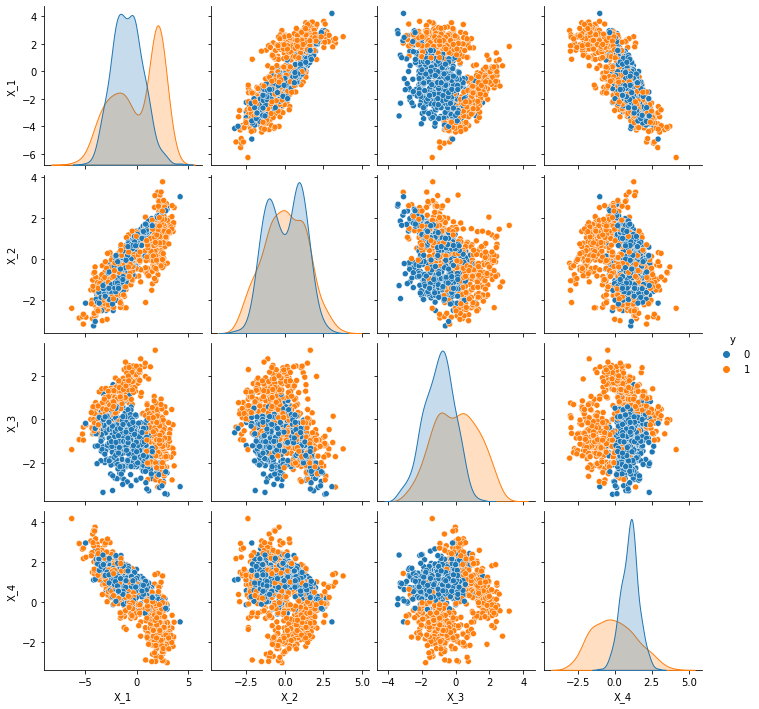

In [ ]:
# EDA helps us understand which variables are likely to be fruitful.
# We can see from these plots that X_2 demonstrates minimal seperability.
# X_3 shows the greatest seperability.

eda_df = X.copy()
eda_df['y'] = y

sns.pairplot(eda_df,hue='y')

## **Splitting Data and Defining Models**

Here we have used a simple train-test split. A more robust approach may be to use K-fold Cross-validation and average over the folds. However this is computationally expensive.

In [ ]:
from sklearn import linear_model as lm #lm.LogisticRegression
from sklearn import svm #svm.SVC
from sklearn import discriminant_analysis as lda #for LDA and QDA
from sklearn import neighbors # K-Nearest Neighbours
from sklearn import ensemble # RandomForest,AdaBoost,GradientBoosting etc.
from sklearn import neural_network # MLPClassifier

class Model:
    '''
    Class for keeping track of Models AUC and 
    which columns of the data the model is using.
    '''
    def __init__(self,cols,model):
        self.cols = cols
        self.model = model

    def update_AUC(self, AUC):
        self.AUC = AUC

# Instantiating list of classifiers, one for each set in powerset of predictors:
# any valid sklearn classifier can be included in the list model_types.
model_types = [lm.LogisticRegression(),
               ensemble.RandomForestClassifier(),
               svm.SVC()]

models = [Model(cols,model_type) for model_type in model_types for cols in powerset(X.columns)]

## **Model Training and Evaluation**

In [ ]:
from sklearn import model_selection

# Calculate AUCs using 10 fold KCV update model objects.
for i,model in enumerate(models):
    model.update_AUC(np.mean(model_selection.cross_val_score(estimator=model.model,X=X[model.cols],y=y, scoring='roc_auc', cv=10)))
    print(f'Trained {model.model} using {model.cols}, Mean AUC = {model.AUC}')

Trained LogisticRegression() using ['X_1'], Mean AUC = 0.636092468987595
Trained LogisticRegression() using ['X_2'], Mean AUC = 0.4735978551420569
Trained LogisticRegression() using ['X_1', 'X_2'], Mean AUC = 0.7302615126050418
Trained LogisticRegression() using ['X_3'], Mean AUC = 0.7260153021208484
Trained LogisticRegression() using ['X_1', 'X_3'], Mean AUC = 0.8361050020008003
Trained LogisticRegression() using ['X_2', 'X_3'], Mean AUC = 0.748255462184874
Trained LogisticRegression() using ['X_1', 'X_2', 'X_3'], Mean AUC = 0.8552283953581432
Trained LogisticRegression() using ['X_4'], Mean AUC = 0.7419012725090035
Trained LogisticRegression() using ['X_1', 'X_4'], Mean AUC = 0.7609828411364548
Trained LogisticRegression() using ['X_2', 'X_4'], Mean AUC = 0.7538224729891956
Trained LogisticRegression() using ['X_1', 'X_2', 'X_4'], Mean AUC = 0.8187062505002001
Trained LogisticRegression() using ['X_3', 'X_4'], Mean AUC = 0.8536284273709484
Trained LogisticRegression() using ['X_1', '

In [ ]:
# Rank Models by AUC 
top_models = sorted(models, key = lambda model: model.AUC, reverse=True)

# print("Models Ranked By AUC:")
# for idx,model in enumerate(top_models):
#     if model.model is model_types[2]:
#         print(f"{idx}: {model.model} with AUC={model.AUC}, using predictors {model.cols}.")

print("Best Performers:")
for idx,model in enumerate(top_models[0:3]):
    print(f" {model.model} with AUC={model.AUC}, using predictors {model.cols}.")

print("\nWorst Performers:")
for idx,model in enumerate(top_models[-3:]):
    print(f" {model.model} with AUC={model.AUC}, using predictors {model.cols}.")    

Best Performers:
 SVC() with AUC=0.9750381912765107, using predictors ['X_2', 'X_3', 'X_4'].
 SVC() with AUC=0.9739980632252901, using predictors ['X_1', 'X_2', 'X_3', 'X_4'].
 SVC() with AUC=0.9726779031612646, using predictors ['X_1', 'X_2', 'X_3'].

Worst Performers:
 SVC() with AUC=0.6009675710284114, using predictors ['X_2'].
 RandomForestClassifier() with AUC=0.5230660024009605, using predictors ['X_2'].
 LogisticRegression() with AUC=0.4735978551420569, using predictors ['X_2'].


## ROC Visualisation

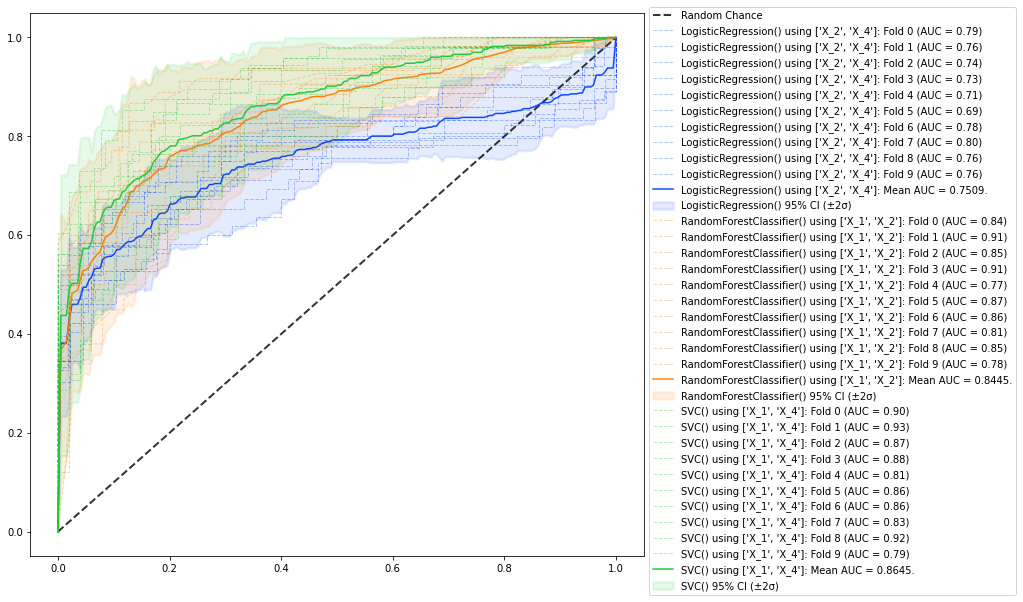

In [ ]:
# ROC plots over KCV folds, for median models of each model type
from math import floor 
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import KFold

#obtain median models of each type 
median_models = dict()
for model_type in model_types:
    models_of_this_type = list(filter(lambda x: x.model is model_type, top_models))
    median_models[str(model_type)] = models_of_this_type[1+floor(len(models_of_this_type)/2)]

# KCV on classifier with ROC curves
kcv = KFold(n_splits=10)

fig, ax = plt.subplots()
colors = sns.color_palette('bright', len(model_types))

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="black", label="Random Chance", alpha=0.8)

for idx,model_type in enumerate(model_types):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 200)

    for i, (train, test) in enumerate(kcv.split(X, y)):
        median_models[str(model_type)].model.fit(X.loc[train,median_models[str(model_type)].cols], y[train])
        viz = RocCurveDisplay.from_estimator(
            median_models[str(model_type)].model,
            X.loc[test,median_models[str(model_type)].cols],
            y[test],
            name=f"{median_models[str(model_type)].model} using {median_models[str(model_type)].cols}: Fold {i}",
            alpha=0.3,
            lw=1,
            linestyle='--',
            ax=ax,
            color=colors[idx]
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)


    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color=colors[idx],
        label=f"{median_models[str(model_type)].model} using {median_models[str(model_type)].cols}: Mean AUC = {mean_auc:.4f}.",
        lw=1.5,
        alpha=0.95,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_ub = np.minimum(mean_tpr + 2*std_tpr, 1)
    tprs_lb = np.maximum(mean_tpr - 2*std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lb,
        tprs_ub,
        color=colors[idx],
        alpha=0.1,
        lw = 2.5,
        label=f"{median_models[str(model_type)].model} 95% CI (±2σ)",
    )

plt.xlabel(None)
plt.ylabel(None)

ax.legend(bbox_to_anchor=(1,1.02))
fig.set_size_inches(11,10)
plt.show()

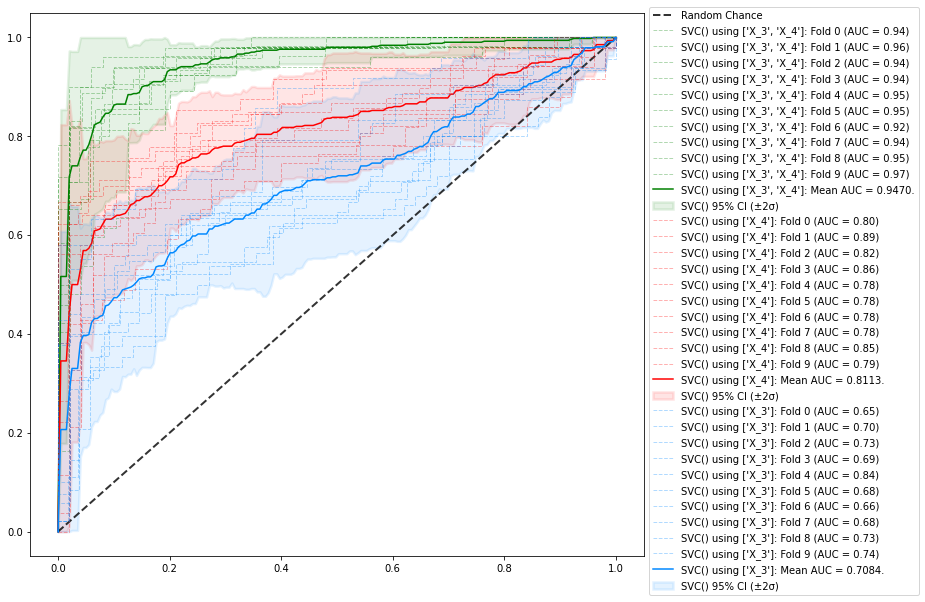

In [ ]:
# ROC plots over KCV folds, for three handpicked models

models_to_plot = [top_models[9], top_models[27], top_models[39]]

fig, ax = plt.subplots()
colors = ['g','r','#0088FF']

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="black", label="Random Chance", alpha=0.8)

for idx,model in enumerate(models_to_plot):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 200)

    for i, (train, test) in enumerate(kcv.split(X, y)):
        model.model.fit(X.loc[train,model.cols], y[train])
        viz = RocCurveDisplay.from_estimator(
            model.model,
            X.loc[test,model.cols],
            y[test],
            name=f"{model.model} using {model.cols}: Fold {i}",
            alpha=0.3,
            lw=1,
            linestyle='--',
            ax=ax,
            color=colors[idx]
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)


    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color=colors[idx],
        label=f"{model.model} using {model.cols}: Mean AUC = {mean_auc:.4f}.",
        lw=1.5,
        alpha=1,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_ub = np.minimum(mean_tpr + 2*std_tpr, 1)
    tprs_lb = np.maximum(mean_tpr - 2*std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lb,
        tprs_ub,
        color=colors[idx],
        alpha=0.1,
        lw = 2.5,
        label=f"{model.model} 95% CI (±2σ)",
    )

plt.xlabel(None)
plt.ylabel(None)

ax.legend(bbox_to_anchor=(1,1.02))
fig.set_size_inches(11,10)
plt.show()

## AUC Comparison

In [ ]:
'''
This codeblock identifies the AUC associated to all models,
 and for each predictor X_i, creates a new partition of the data,
 into two groups: 
      1) models which include X_i. 
      2) models which exclude X_i.
 It stores all the AUC data from all models, 
 and then calculates the mean gain/loss in AUC due to X_i's inclusion.
'''

AUC_data = np.ndarray(shape=(1,3))

# tracking the mean and SD of AUC gains
mean_AUC_gains = dict()
sd_AUC_gains = dict()

for col in X.columns:
    AUCs_with = np.array([model.AUC for model in list(filter(lambda x: str(col) in x.cols, models))])
    AUCs_without = np.array([model.AUC for model in list(filter(lambda x: str(col) not in x.cols, models))])

    mean_AUC_gains[col] = np.mean(AUCs_with) - np.mean(AUCs_without)
    sd_AUC_gains[col] = np.sqrt((np.var(AUCs_with)/len(AUCs_with)) + (np.var(AUCs_without)/len(AUCs_without)))

    AUC_data = np.vstack((AUC_data,np.c_[AUCs_with,np.repeat('Including',len(AUCs_with)),np.repeat(col,len(AUCs_with))]))
    AUC_data = np.vstack((AUC_data,np.c_[AUCs_without,np.repeat('Excluding',len(AUCs_without)),np.repeat(col,len(AUCs_without))]))

mean_AUC_gains = pd.Series(mean_AUC_gains)
sd_AUC_gains = pd.Series(sd_AUC_gains)
AUC_data = np.delete(AUC_data, (0), axis=0)

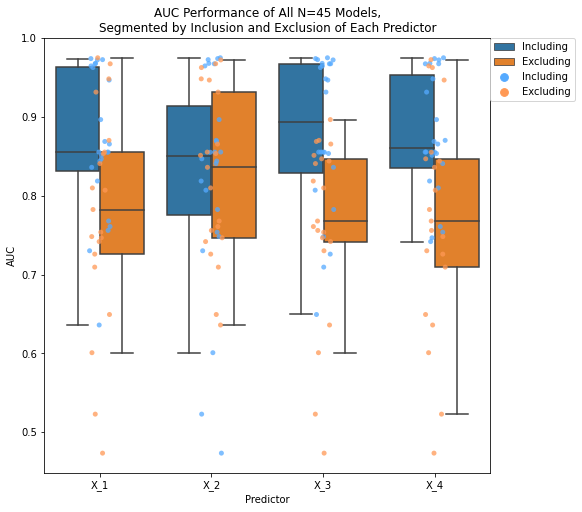

In [ ]:
#  Using that data we can visualise a boxplot of AUC along those partitions.
plot_df = pd.DataFrame(AUC_data, columns=['AUC','Inclusion','Predictor'])

plot_df['AUC'] = pd.to_numeric(plot_df['AUC'])

plt.figure(figsize=(8,8))
ax = sns.boxplot(x="Predictor", y="AUC", hue="Inclusion", data = plot_df, flierprops = dict(markerfacecolor = '0.50', markersize = 0)).set(title=f'AUC Performance of All N={len(models)} Models,\nSegmented by Inclusion and Exclusion of Each Predictor')
ax = sns.stripplot(x="Predictor", y="AUC", hue="Inclusion", data = plot_df, alpha=0.75, palette=['#55AAFF','#FF9955'])
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

Text(0.5, 1.0, 'Contribution of Each Predictor\nRanked by Estimated Gain in Mean AUC (95% CI)')

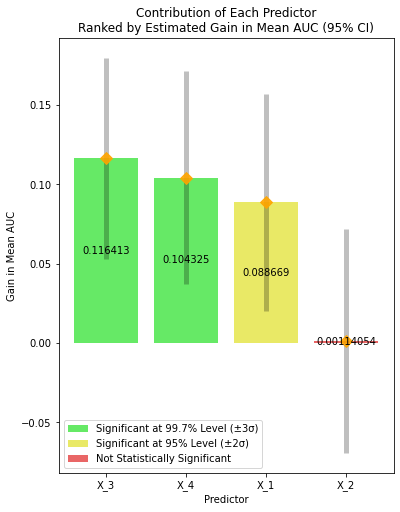

In [ ]:
from numpy.ma.core import std
# Visualising the significance of each predictor as 'Mean AUC Gained'
final = pd.DataFrame(np.c_[X.columns,mean_AUC_gains,2*sd_AUC_gains,np.int8(mean_AUC_gains>2*sd_AUC_gains)+(mean_AUC_gains>3*sd_AUC_gains)], columns=['Predictor','Gain in Mean AUC','95CI','Significance'])
final = final.sort_values(ascending=False, by='Gain in Mean AUC')

final['Significance'] = final['Significance'].map(dict(enumerate(['Not Statistically Significant','Significant at 95% Level (±2σ)','Significant at 99.7% Level (±3σ)'])))

plt.figure(figsize=(6,8))
ax = sns.barplot(x='Predictor',y='Gain in Mean AUC',data=final, hue='Significance', dodge=False, palette=["#50FF50","#FFFF50","#FF5050"])
for container in ax.containers:
    ax.bar_label(container, label_type='center')
ax.legend()
plt.errorbar(x='Predictor',
             y='Gain in Mean AUC',
             yerr='95CI',ls='',lw=4,
             data=final,
             elinewidth = 5,
             ecolor='black',
             capsize=0,
             alpha=0.25)
plt.errorbar(x='Predictor',
             y='Gain in Mean AUC',
             yerr='95CI',
             data=final,
             color='orange',
             fmt = 'D',
             alpha=0.9,
             markersize=9,
             elinewidth = 0,
             capsize=0)
ax.set_title('Contribution of Each Predictor\nRanked by Estimated Gain in Mean AUC (95% CI)')

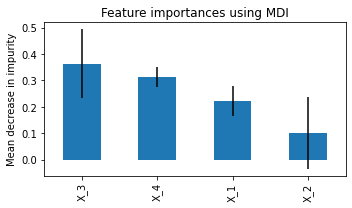

In [ ]:
# Random Forest Feature importance based on Mean Decrease in Node Impurity

forest=ensemble.RandomForestClassifier().fit(X,y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
fig.set_size_inches(5, 3)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Observations from this Boxplot

We can see from this boxplot that variable X_2 yields minimal improvement when included vs when excluded. By comparison all other variables show a considerable improvement to AUC, especially X_3. This corroborates our intuition based off the exploratory visualisation using the pairs plot.


# **SHAP Application**?
By Linxuan

In [ ]:
!pip install shap==0.39.0
import shap
from sklearn.ensemble import RandomForestClassifier

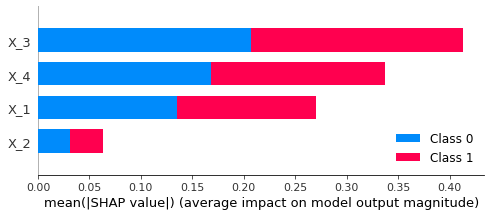

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X, y)
fig = plt.figure()
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, features=X, feature_names=X.columns)